In [1]:
from IPython.core.display import HTML
import os
styles = open(os.path.join('.', 'custom4.css'), 'r').read()
HTML(styles)

* Caveats

*requires PyRosetta4, Python 2.7, pandas, seaborn, jupyter*

This also assumes the reader is coming in after reading the original PyRosetta manual and chapters & is familiar with Pandas and plotting

This is just a demo/prototype to get a feel for what we can do

The energy function is hard coded at the moment - which is why the energy from the dataframe doesn't match the energy from the sfxn

Not all explainations are perfect

I'm not a css/js person so we definitely need to hire a design person for the book

Your results may vary (I haven't set the seeds so you repack may differ)

Yes, the algorithms introduced here are terrible. They are for edification, show and play, not for real science.

# Breaking down energy changes from packing in Rosetta

#### Copyright Rosetta Commons Member Institutions. This file is part of the Rosetta software suite and is made available under license. The Rosetta software is developed by the contributing members of the Rosetta Commons. For more information, see https://www.rosettacommons.org. Questions about this can be addressed to University of Washington CoMotion, email: license@uw.edu.

 ## Using PyRosetta to follow the energy minimization of the packer
 
This notebook covers the following topics

<a id='MainChapterIndex'></a>

- [1](#section1) --  Setting up a Pose & extracting the energy into a Pandas DataFrame   


- [2](#section2) --  Setting up a Packer Task to only allow residues 1 and 2 to repack   


- [3](#section3) --  Writing a new packing algorithm based on selecting the residue with the worst energy   


- [4](#section4) --  Fixing the packing algorithm when it gets stuck in local energy minima   
 
 

 
This notebook will detail the steps need to extract information out of a running packer task in rosetta.Let's begin by starting rosetta and loading a protein. In the first cell, be sure to execute it. This will bring in all of the libraries that we will be using for this chapter.

<a id='section1'></a>

## Section 1 -- Setting up a Pose & extracting the energy into a Pandas DataFrame
[Take me back to the index](#MainChapterIndex)

In [32]:
import rosetta
import pyrosetta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from rosetta.core.scoring.methods import EnergyMethodOptions
import pandas as pd
import matplotlib.ticker as ticker

sns.set_style('darkgrid')

In [85]:
# See FAQ for explanations of these flags
pyrosetta.init('-mute core basic -prevent_repacking T -ignore_unrecognized_res T ')

Found rosetta database at: /home/steve/anaconda/envs/DebugPyRosetta/lib/python2.7/site-packages/pyrosetta-4.0-py2.7.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:40ccfaf8273337b4eb91cd59f05ccbfceef78c87 2016-08-30 16:18:01 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



Now, having just read in this structure, it will be nice to 

- visualize it to look for missing residues

- score it with an energy function

- store that data for comparison once we allow rosetta to minimize the structure over different degrees of     freedom


Rosetta's scorefunction is a rather complex subject. Feel free to checkout the following places for more specific details on it.

- Energy Function Paper

- Reference Notebook on how to reproduce the score in PyRosetta

- Reference Notebook on energy function


In [86]:
sfxn = rosetta.core.scoring.ScoreFunctionFactory.create_score_function('talaris2013')

In [87]:
# now we need a protein
p = pyrosetta.pose_from_file('1ubq.pdb')
print sfxn(p)

73.5012653727


Great, so now we have loaded a pdb from a file, internally Rosetta creates an object called a *Pose* which is the main object that stores everything we know about the protein. For example, in different layers of the *Pose* object, you can access the current energy, add restraints, identify all of the Prolines, measure distances, etc.

Our score perhaps leaves something to be desired The score we got out refers to the whole protein structure, but as you may be aware, there are many different energy terms in the scorefunction. So what we just got back was the weighted sum of all of those individual score terms.

Is there someway we can break it down so that we can sum it up ourselves/??

Yes there is and the short answer is we will use Pandas DataFrames to do so

In [6]:
#### This function is used to get a dataframe of all per residues scores in the pose
def dataframe_from_pose_and_sfxn(p, sfxn):
    '''
    Takes a Rosetta Pose and a scorefunction, then returns a dataframe
    of the Per-residues weighted scoreterms, including hbond_bb (which get zeroed out
    by default)

    '''

    
    current_energy_methods_options = sfxn.energy_method_options() #keep current options
    emo = EnergyMethodOptions( current_energy_methods_options)    #must do this to get per res hbond_bb terms in breakdown
    emo.hbond_options().decompose_bb_hb_into_pair_energies( True )  # set to true, defaults False
    sfxn.set_energy_method_options( emo ) #set the sfxn up with the energy method options

    
    import ast
    # hack for example to work
    sfxnweights = ast.literal_eval("{'fa_atr': 0.8, 'fa_rep': 0.44, 'fa_sol': 0.75, 'fa_intra_rep': 0.004, 'fa_elec': 0.7, 'pro_close': 1, 'hbond_sr_bb': 1.17, 'hbond_lr_bb': 1.17, 'hbond_bb_sc': 1.17, 'hbond_sc': 1.1, 'dslf_fa13': 1, 'rama': 0.2, 'omega': 0.5, 'fa_dun': 0.56, 'p_aa_pp': 0.32, 'ref': 1}")
    
    listofseries = []
    
    for i in range(1,p.total_residue() +1):
        mydict = {}
        for j in sfxnweights.keys():
            
            mydict[j] = float(sfxnweights[j])*p.energies().residue_total_energies(i)[ rosetta.core.scoring.ScoreTypeManager.score_type_from_name(j) ]
            
        listofseries.append(pd.Series(mydict))

    df = pd.DataFrame(listofseries)
    df.index +=1 # residues start from 1
    
    return df


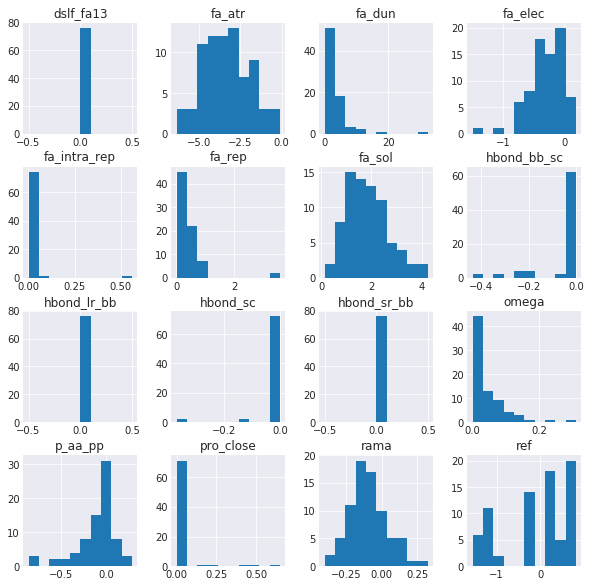

In [7]:
d = dataframe_from_pose_and_sfxn( p, sfxn )

d.hist(figsize=(10,10));

Ok, so what have we done and what does this tell us?

We have load a pdb file (1ubq) into rosetta and created a Pose object. We have also create a scorefunction and score our protein. Last, we import the useful python library pandas so that we can look deeper into the score.

What we can see in our energy function, is that there are a few terms that appear unimodal (like dsfld_13 <- a term for disulfide bonds)

So, there are 3 ways we can check to see why that is the case. 

    1- Check the dataframe for energies in that column

In [76]:
d.dslf_fa13.head()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: dslf_fa13, dtype: float64

And we see that all of the terms are 0.   But why are they zero? Perhaps there are no disulfides detected...

    2- Query the conformation layer to see if it detects sulfides

In [9]:
conf = p.conformation()

print conf.detect_disulfides()

None


Ok, so there are no disfulide bond.  But are there any cysteine residues? Maybe Rosetta just isn't detecting the disfulides correctly.

    3- Check the protein for Cysteine residues

In [10]:
for i in range(1,p.total_residue()+1):
    if p.residue(i).name() == 'CYS':
        print p.residue(i).name()

So now we finally arrive at the conclusion that there are no cysteines, hence no disfulides, and therefore our unimodal dsfd energy term is a just a bunch of 0.00's



The next thing we might want todo is to look into the energy dataframe. Here's a slice

In [11]:
d.head()

,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,pro_close,rama,ref
1,0.0,-4.228063,4.183688,-0.788563,0.008626,0.440478,2.381175,0.0,0.0,0.0,0.0,0.014325,0.000000,0.0,0.000000,0.158677
2,0.0,-2.711662,4.391038,-0.354802,0.005483,0.103631,1.714730,0.0,0.0,0.0,0.0,0.220519,-0.014081,0.0,-0.159911,-1.177970
3,0.0,-4.525690,0.559269,-0.399025,0.009071,0.105186,1.365036,0.0,0.0,0.0,0.0,0.000927,-0.150230,0.0,-0.067601,0.831803
4,0.0,-5.088347,1.457668,-0.458006,0.021662,0.567937,2.179498,0.0,0.0,0.0,0.0,0.088437,-0.149437,0.0,-0.170721,0.430570
5,0.0,-4.124108,0.017596,-0.471249,0.010701,0.239889,1.409207,0.0,0.0,0.0,0.0,0.017748,-0.331413,0.0,-0.153348,0.744844


What we see is each pose residue number and all of the energy terms broken down. This might actually be too much data, maybe we just want to track changes in individual energy terms. To accomplish that, we just need to sum up each energy term. This is trivially accomplished in the dataframe.

In [44]:
d.sum()

dslf_fa13         0.000000
fa_atr         -251.795476
fa_dun          227.147177
fa_elec         -21.877033
fa_intra_rep      1.381880
fa_rep           33.049298
fa_sol          140.765241
hbond_bb_sc      -3.418767
hbond_lr_bb       0.000000
hbond_sc         -0.978310
hbond_sr_bb       0.000000
omega             3.373518
p_aa_pp          -8.026246
pro_close         1.906105
rama             -7.254262
ref              -8.531904
dtype: float64

And as a reminder, we can always get the total protein energy by adding 1 more call to .sum

In [13]:
d.sum().sum()

105.74122145170412

Which, you may recall from above is the energy of our protein when we asked rosetta to score it.

<a id='section2'></a>
## 2 --  Setting up a Packer Task to only allow residues 1 and 2 to repack
[Take me back to the index](#MainChapterIndex)

Okay, now let's try something. We will use Rosetta to sample different rotamers in the protein in order to try and find a lower energy solution to the structure. We should be able to track all of the changes in energy and compare to identify where the change happened.

In [14]:
tf = rosetta.core.pack.task.TaskFactory()
pt = tf.create_packer_task(p)

print pt

#Packer_Task

resid	pack?	design?	allowed_aas
1	TRUE	TRUE	ALA:NtermProteinFull,CYS:NtermProteinFull,ASP:NtermProteinFull,GLU:NtermProteinFull,PHE:NtermProteinFull,GLY:NtermProteinFull,HIS:NtermProteinFull,HIS_D:NtermProteinFull,ILE:NtermProteinFull,LYS:NtermProteinFull,LEU:NtermProteinFull,MET:NtermProteinFull,ASN:NtermProteinFull,PRO:NtermProteinFull,GLN:NtermProteinFull,ARG:NtermProteinFull,SER:NtermProteinFull,THR:NtermProteinFull,VAL:NtermProteinFull,TRP:NtermProteinFull,TYR:NtermProteinFull
2	TRUE	TRUE	ALA,CYS,ASP,GLU,PHE,GLY,HIS,HIS_D,ILE,LYS,LEU,MET,ASN,PRO,GLN,ARG,SER,THR,VAL,TRP,TYR
3	TRUE	TRUE	ALA,CYS,ASP,GLU,PHE,GLY,HIS,HIS_D,ILE,LYS,LEU,MET,ASN,PRO,GLN,ARG,SER,THR,VAL,TRP,TYR
4	TRUE	TRUE	ALA,CYS,ASP,GLU,PHE,GLY,HIS,HIS_D,ILE,LYS,LEU,MET,ASN,PRO,GLN,ARG,SER,THR,VAL,TRP,TYR
5	TRUE	TRUE	ALA,CYS,ASP,GLU,PHE,GLY,HIS,HIS_D,ILE,LYS,LEU,MET,ASN,PRO,GLN,ARG,SER,THR,VAL,TRP,TYR
6	TRUE	TRUE	ALA,CYS,ASP,GLU,PHE,GLY,HIS,HIS_D,ILE,LYS,LEU,MET,ASN,PRO,GLN,ARG,SER,THR,VAL,TRP,TYR
7	TRUE	TR

Ok, so we have a default packer task setup in Rosetta (pro-tip, notice that by default Rosetta allows design of residues!)

But for our experiment, we will need to restrict it down to repacking (by turning design off) and then further carve away (as in carve an ice sculpture, the packer is commutative in the algebraic sense) by turning off packing on every residue except the one we want

In [15]:
mymask = rosetta.utility.vector1_bool()
for i in range(1,p.total_residue()+1):
    if i != 1:
        mymask.append(False)
    else:
        mymask.append(True)
print mymask

pt.restrict_to_repacking();

# This is the function that I want to use.
# if you put a question mark at the end and execute the cell, you will see
# that it takes a vector1 of booleans. That's why we are constructing one,
# so that we can pass it into this function 

#pt.restrict_to_residues

vector1_bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
print pt

#Packer_Task

resid	pack?	design?	allowed_aas
1	TRUE	FALSE	MET:NtermProteinFull
2	TRUE	FALSE	GLN
3	TRUE	FALSE	ILE
4	TRUE	FALSE	PHE
5	TRUE	FALSE	VAL
6	TRUE	FALSE	LYS
7	TRUE	FALSE	THR
8	TRUE	FALSE	LEU
9	TRUE	FALSE	THR
10	TRUE	FALSE	GLY
11	TRUE	FALSE	LYS
12	TRUE	FALSE	THR
13	TRUE	FALSE	ILE
14	TRUE	FALSE	THR
15	TRUE	FALSE	LEU
16	TRUE	FALSE	GLU
17	TRUE	FALSE	VAL
18	TRUE	FALSE	GLU
19	TRUE	FALSE	PRO
20	TRUE	FALSE	SER
21	TRUE	FALSE	ASP
22	TRUE	FALSE	THR
23	TRUE	FALSE	ILE
24	TRUE	FALSE	GLU
25	TRUE	FALSE	ASN
26	TRUE	FALSE	VAL
27	TRUE	FALSE	LYS
28	TRUE	FALSE	ALA
29	TRUE	FALSE	LYS
30	TRUE	FALSE	ILE
31	TRUE	FALSE	GLN
32	TRUE	FALSE	ASP
33	TRUE	FALSE	LYS
34	TRUE	FALSE	GLU
35	TRUE	FALSE	GLY
36	TRUE	FALSE	ILE
37	TRUE	FALSE	PRO
38	TRUE	FALSE	PRO
39	TRUE	FALSE	ASP
40	TRUE	FALSE	GLN
41	TRUE	FALSE	GLN
42	TRUE	FALSE	ARG
43	TRUE	FALSE	LEU
44	TRUE	FALSE	ILE
45	TRUE	FALSE	PHE
46	TRUE	FALSE	ALA
47	TRUE	FALSE	GLY
48	TRUE	FALSE	LYS
49	TRUE	FALSE	GLN
50	TRUE	FALSE	LEU
51	TRUE	FALSE	GLU
52	TRUE	FALSE	ASP
53	TRUE	FA

Side note - although we will move on to our goal, note here that His has 2 forms. On the left we have HIS and on the right we have HIS_D. If you look at output from Rosetta, you will note that the HIS has a hydrogen attached at the nitrogen atom (called NE2; see the Rosetta database Rosetta/main/database/chemical/residue_type_sets/fa_standard/residue_types/l-caa/HIS.params ). On the right hand side, the hydrogen is attached at the ND1 nitrogen atom, hence HIS_D


<table><tr><td><img src='his.png' height='200' width='200'></td><td><img src='his_d.png' height='200' width='200'></td></tr></table>



In [17]:
pt.restrict_to_residues(mymask)
print pt

#Packer_Task

resid	pack?	design?	allowed_aas
1	TRUE	FALSE	MET:NtermProteinFull
2	FALSE	FALSE	
3	FALSE	FALSE	
4	FALSE	FALSE	
5	FALSE	FALSE	
6	FALSE	FALSE	
7	FALSE	FALSE	
8	FALSE	FALSE	
9	FALSE	FALSE	
10	FALSE	FALSE	
11	FALSE	FALSE	
12	FALSE	FALSE	
13	FALSE	FALSE	
14	FALSE	FALSE	
15	FALSE	FALSE	
16	FALSE	FALSE	
17	FALSE	FALSE	
18	FALSE	FALSE	
19	FALSE	FALSE	
20	FALSE	FALSE	
21	FALSE	FALSE	
22	FALSE	FALSE	
23	FALSE	FALSE	
24	FALSE	FALSE	
25	FALSE	FALSE	
26	FALSE	FALSE	
27	FALSE	FALSE	
28	FALSE	FALSE	
29	FALSE	FALSE	
30	FALSE	FALSE	
31	FALSE	FALSE	
32	FALSE	FALSE	
33	FALSE	FALSE	
34	FALSE	FALSE	
35	FALSE	FALSE	
36	FALSE	FALSE	
37	FALSE	FALSE	
38	FALSE	FALSE	
39	FALSE	FALSE	
40	FALSE	FALSE	
41	FALSE	FALSE	
42	FALSE	FALSE	
43	FALSE	FALSE	
44	FALSE	FALSE	
45	FALSE	FALSE	
46	FALSE	FALSE	
47	FALSE	FALSE	
48	FALSE	FALSE	
49	FALSE	FALSE	
50	FALSE	FALSE	
51	FALSE	FALSE	
52	FALSE	FALSE	
53	FALSE	FALSE	
54	FALSE	FALSE	
55	FALSE	FALSE	
56	FALSE	FALSE	
57	FALSE	FALSE	
58	FALSE	FALSE	
59	FALSE	FALSE	


Almost there! Now we have setup the packer task to just pack the one residue we are interested in.

Let's wrap all of that into a function that will take a pose  and residue number (or numbers) and give us back a packer task.

In [18]:
def take_pose_restrict_to_repacking_for_residues(p,myres):
    tf = rosetta.core.pack.task.TaskFactory()
    pt = tf.create_packer_task(p)
    
    mymask = rosetta.utility.vector1_bool()
    for i in range(1,p.total_residue()+1):
        if i not in myres:
            mymask.append(False)
        else:
            mymask.append(True)
    #print mymask

    pt.restrict_to_repacking()
    pt.restrict_to_residues(mymask)
    return pt

mypt = take_pose_restrict_to_repacking_for_residues(p,set([1,2]))
print mypt

#Packer_Task

resid	pack?	design?	allowed_aas
1	TRUE	FALSE	MET:NtermProteinFull
2	TRUE	FALSE	GLN
3	FALSE	FALSE	
4	FALSE	FALSE	
5	FALSE	FALSE	
6	FALSE	FALSE	
7	FALSE	FALSE	
8	FALSE	FALSE	
9	FALSE	FALSE	
10	FALSE	FALSE	
11	FALSE	FALSE	
12	FALSE	FALSE	
13	FALSE	FALSE	
14	FALSE	FALSE	
15	FALSE	FALSE	
16	FALSE	FALSE	
17	FALSE	FALSE	
18	FALSE	FALSE	
19	FALSE	FALSE	
20	FALSE	FALSE	
21	FALSE	FALSE	
22	FALSE	FALSE	
23	FALSE	FALSE	
24	FALSE	FALSE	
25	FALSE	FALSE	
26	FALSE	FALSE	
27	FALSE	FALSE	
28	FALSE	FALSE	
29	FALSE	FALSE	
30	FALSE	FALSE	
31	FALSE	FALSE	
32	FALSE	FALSE	
33	FALSE	FALSE	
34	FALSE	FALSE	
35	FALSE	FALSE	
36	FALSE	FALSE	
37	FALSE	FALSE	
38	FALSE	FALSE	
39	FALSE	FALSE	
40	FALSE	FALSE	
41	FALSE	FALSE	
42	FALSE	FALSE	
43	FALSE	FALSE	
44	FALSE	FALSE	
45	FALSE	FALSE	
46	FALSE	FALSE	
47	FALSE	FALSE	
48	FALSE	FALSE	
49	FALSE	FALSE	
50	FALSE	FALSE	
51	FALSE	FALSE	
52	FALSE	FALSE	
53	FALSE	FALSE	
54	FALSE	FALSE	
55	FALSE	FALSE	
56	FALSE	FALSE	
57	FALSE	FALSE	
58	FALSE	FALSE	
59	FALSE	FALSE

In [19]:
test_pose = rosetta.core.pose.Pose()

test_pose.assign(p)

packrot = rosetta.protocols.simple_moves.PackRotamersMover(sfxn,mypt)

print packrot

sfxn(test_pose) #just check to make sure the energies are the same

packrot.apply(test_pose)

df_test = dataframe_from_pose_and_sfxn(test_pose,sfxn)

sfxn(test_pose)

Mover name: PackRotamersMover, Mover type: PackRotamersMover, Mover current tag:NoTag
Score function: talaris2013



71.04022112633915

Okay! Success, so first off, we see the output from the the core pack where it tells us it repacking at 2 positions and samples 24 rotamers in total - each amino acid type has a certain number of rotamers, and rosetta does some fancy things to sample rotamers efficiently - ref alf paper on the packer

And, we also get a new dataframe, so if we diff the starting dataframe and the ending dataframe, the places that changes are residues that interact with position 1 and 2

if they didn't interact with those residues, then the energy never would have changed

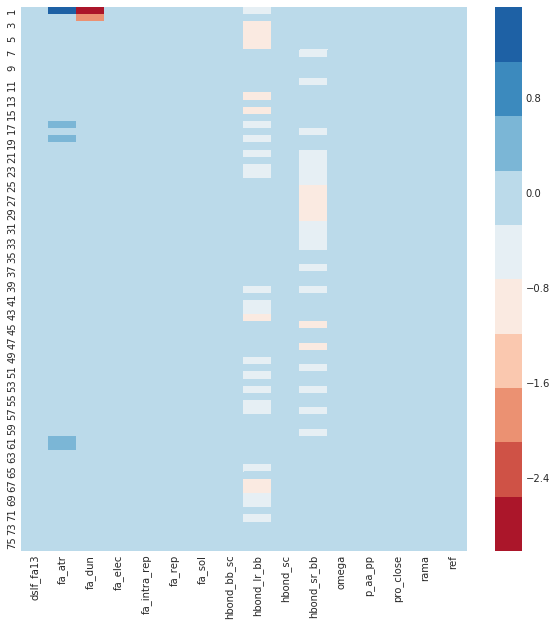

In [20]:
cmap = sns.color_palette('RdBu',10)

diff = df_test - d
plt.figure(figsize=(10,10))
sns.heatmap(diff, cmap=cmap)
plt.show()

So that's all well and good, I guess right away you can see that there are a lot of terms that didn't change, there are some drastic changes on residues 1 and 2 and a lot of the changes affected the hbond_lr_bb and hbond_sr_bb terms

Let's clean this up and remove any column that didn't change

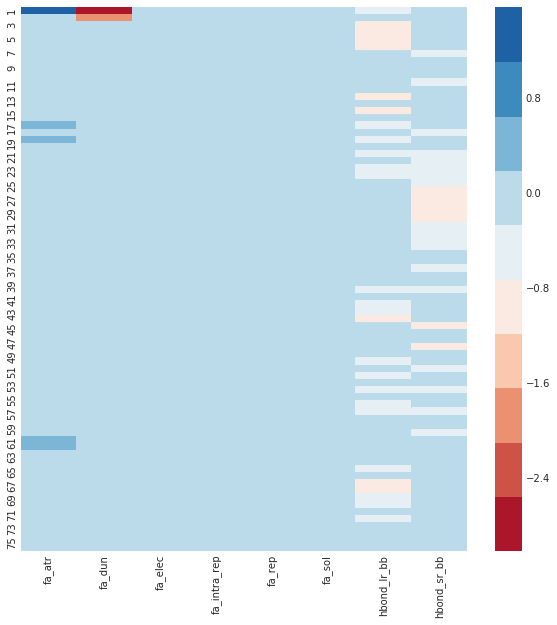

In [21]:
droppedzeros = diff.loc[:,(diff !=0).any(axis=0)]

plt.figure(figsize=(10,10))
sns.heatmap(droppedzeros, cmap=cmap)
plt.show()

<a id='section3'></a>
## 3 --  Writing a new packing algorithm based on selecting the residue with the worst energy
[Take me back to the index](#MainChapterIndex)

Okay, so now we have some tools we have built. What can we do with them? We could write differente algorithms to repack protiens and then see which one lowers the energy faster.

Let's try this. Let's write an algorithm 1 that will select the residue that has the worst energy, repacks it and then moves on to the next worst in energy residue.

Algorithm 2 will select a residue at random and repacking. Which one do you think will work better?

One important part of this is determing what we mean by "worst energy". Does that mean the highest (most positive) overall energy for the residue? Or does it just mean it has a bad fa_atr, fa_rep or fa_dun score? These are good questions and we can basically test them all. For our purposes, we will choose the highest overall residue energy.

The really cool thing here, is that because our energies are already in a dataframe, to get the energy per residue number, we just need to sum over the other axis

In [22]:
## Let's see if we did that right.
d.sum(axis=1).head()

1    2.170341
2    2.016975
3   -2.271253
4   -1.120740
5   -2.640133
dtype: float64

In [23]:
# this is a bit "squished" but it's easy to recreate
# start by summing the energies, then sort them to get the highest value
# at the top, then use head(1) to pop off that 1 residue, then pull out of the
# result the actual numerical residue number
mysum = d.sum(axis=1)
residue_with_highest_energy = mysum.sort_values(ascending=False).head(1).index[0]

In [24]:
## algorithm 1
## start with a fresh copy
test_pose = test_pose.assign(p)
sfxn(test_pose)
numsteps = 1
print "repacking %s times with Algo1" %numsteps
for i in range(1,numsteps+1):
    print "step -%s" %i
    print "starting energy %s " %sfxn(test_pose)

    en = dataframe_from_pose_and_sfxn(test_pose,sfxn)
        
    residue_with_highest_energy = en.sum(axis=1).sort_values(ascending=False).head(1).index[0]
    print "Repacking this residues - %s" %residue_with_highest_energy
    
    mypt = take_pose_restrict_to_repacking_for_residues(test_pose,[residue_with_highest_energy])
    packrot = rosetta.protocols.simple_moves.PackRotamersMover(sfxn,mypt)
    packrot.apply(test_pose)
    print "energy after repacking at position %s - %s " %(residue_with_highest_energy, sfxn(test_pose) )

repacking 1 times with Algo1
step -1
starting energy 73.5012653727 
Repacking this residues - 13
energy after repacking at position 13 - 44.0546852853 


Looks like we're in business. So this allows us to run our first algorithm, the last
thing we want is to store the data so that we can plot how the energy changes as it cycles

Let's create a dict which stores the index of the step number and the overall protein score

In [25]:
## algorithm 1
## start with a fresh copy
test_pose = test_pose.assign(p)
sfxn(test_pose)
numsteps = 3
listofdata = []
print "repacking %s times with Algo1" %numsteps
for i in range(1,numsteps+1):
    print "step -%s" %i
    print "starting energy %s " %sfxn(test_pose)

    en = dataframe_from_pose_and_sfxn(test_pose,sfxn)
        
    residue_with_highest_energy = en.sum(axis=1).sort_values(ascending=False).head(1).index[0]
    print "Repacking this residues - %s" %residue_with_highest_energy
    
    mypt = take_pose_restrict_to_repacking_for_residues(test_pose,[residue_with_highest_energy])
    packrot = rosetta.protocols.simple_moves.PackRotamersMover(sfxn,mypt)
    packrot.apply(test_pose)
    listofdata.append(pd.Series({'index' : int(i), 'score' : sfxn(test_pose)}))

repacking 3 times with Algo1
step -1
starting energy 73.5012653727 
Repacking this residues - 13
step -2
starting energy 44.0546852853 
Repacking this residues - 72
step -3
starting energy 28.3675298922 
Repacking this residues - 39


so we pack 3 times at 3 different positions and store the data in a dict. We can easily plot this using pandas


17.847572773758877

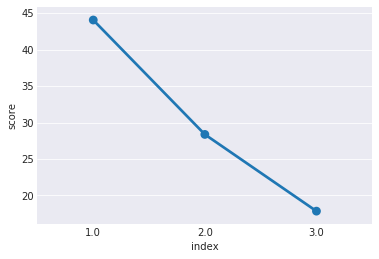

In [26]:
s = pd.concat(listofdata,axis=1)
s = s.T
s.index = s['index']
sns.pointplot('index','score',data=s)
sfxn(test_pose)

So now, let's up the cycles on our algorithm 1 and rerun for 10 steps

Why 10 steps? You'll see ;)


In [27]:
## algorithm 1
## start with a fresh copy
test_pose = test_pose.assign(p)
sfxn(test_pose)
numsteps = 10
listofdata = []
print "repacking %s times with Algo1" %numsteps
for i in range(1,numsteps+1):
    print "step -%s" %i
    print "starting energy %s " %sfxn(test_pose)

    en = dataframe_from_pose_and_sfxn(test_pose,sfxn)
        
    residue_with_highest_energy = en.sum(axis=1).sort_values(ascending=False).head(1).index[0]
    print "Repacking this residues - %s" %residue_with_highest_energy
    
    mypt = take_pose_restrict_to_repacking_for_residues(test_pose,[residue_with_highest_energy])
    packrot = rosetta.protocols.simple_moves.PackRotamersMover(sfxn,mypt)
    packrot.apply(test_pose)
    listofdata.append(pd.Series({'index' : int(i), 'score' : sfxn(test_pose)}))

repacking 10 times with Algo1
step -1
starting energy 73.5012653727 
Repacking this residues - 13
step -2
starting energy 44.0546852853 
Repacking this residues - 72
step -3
starting energy 28.3675298922 
Repacking this residues - 39
step -4
starting energy 17.8475727738 
Repacking this residues - 74
step -5
starting energy 10.3811384244 
Repacking this residues - 64
step -6
starting energy 2.51004750134 
Repacking this residues - 15
step -7
starting energy -6.14815844159 
Repacking this residues - 42
step -8
starting energy 2.84383691877 
Repacking this residues - 42
step -9
starting energy 2.84383691877 
Repacking this residues - 42
step -10
starting energy 2.84383691877 
Repacking this residues - 42


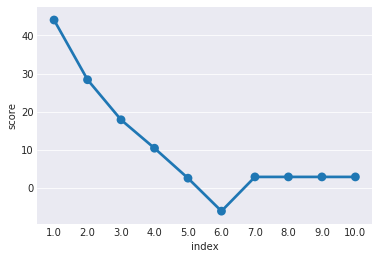

In [28]:
s = pd.concat(listofdata,axis=1)
s = s.T
s.index = s['index']
sns.pointplot('index','score',data=s);

This was going so great! And then it just flattens out and gets stuck!
Although this is just an example, this is a real life problem (in a simulation world)

<a id='section4'></a>
## 4 --  Fixing the packing algorithm when it gets stuck in local energy minima
[Take me back to the index](#MainChapterIndex)

But we can modify this by adding some randomness into our simulation

For example, we can choose the highest energy residue 50% of the time, and the other 50% of the time we will randomly choose a different residue. That way, if we get stuck at least we will get some energy movement

See the example below

In [89]:
import random
def high_energy_or_random(p,worstres):
    '''
    this takes an pose and returns the highest energy residue 50% of the time
    and a random residue the other 50% of the time. This is used to illustrate escaping
    local energy minima
    '''
    highenergyornot = random.random()
    if highenergyornot < 0.5:
        return worstres
    else:
        return random.randint(1,p.total_residue())

Now let's crank up the nsteps and run for 1000 to see how low in energy we can get using this method

For a run like this, it might be helpful to mute the core tracer channel (This has already been done for you, just so you are aware).

pyrosetta.init(' ** -mute core ** -prevent_repacking T -ignore_unrecognized_res T ')


In [90]:
## algorithm 1
## start with a fresh copy
test_pose = rosetta.core.pose.Pose()
test_pose = test_pose.assign(p)
print sfxn(test_pose)
numsteps = 50
listofdata = []
print "repacking %s times with Algo1" %numsteps
for i in range(1,numsteps+1):

    en = dataframe_from_pose_and_sfxn(test_pose,sfxn)
        
    residue_with_highest_energy = en.sum(axis=1).sort_values(ascending=False).head(1).index[0]
    
    residue_with_highest_energy = high_energy_or_random( p, residue_with_highest_energy )
    
    mypt = take_pose_restrict_to_repacking_for_residues(test_pose,[residue_with_highest_energy])
    packrot = rosetta.protocols.simple_moves.PackRotamersMover(sfxn,mypt)
    packrot.apply(test_pose)
    listofdata.append(pd.Series({'index' : int(i), 'score' : sfxn(test_pose)}))
    

repacking 50 times with Algo1


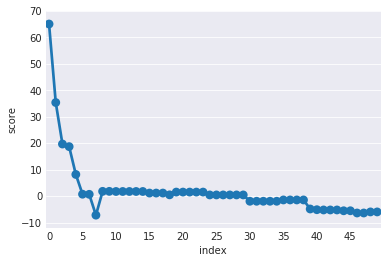

In [91]:
s = pd.concat(listofdata,axis=1)
s = s.T
s.index = s['index']

ax = sns.pointplot('index','score',data=s)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

Well, I promised an algorithm 2 (even though we had to add randomness by necessity). This time, I'll take what we just executed, but instead of using the worst energy residue, I'll just pick at random.

In [92]:
## algorithm 2
## start with a fresh copy
test_pose = rosetta.core.pose.Pose()
test_pose = test_pose.assign(p)
print sfxn(test_pose)
numsteps = 50
listofdata = []
print "repacking %s times with Algo2" %numsteps
for i in range(1,numsteps+1):

    en = dataframe_from_pose_and_sfxn(test_pose,sfxn)

# Turn this off, I don't care which one is worse in energy
#    residue_with_highest_energy = en.sum(axis=1).sort_values(ascending=False).head(1).index[0]
#    residue_with_highest_energy = high_energy_or_random( p, residue_with_highest_energy )

    randomresidue = random.randint(1,p.total_residue())

    mypt = take_pose_restrict_to_repacking_for_residues(test_pose,[randomresidue])
    packrot = rosetta.protocols.simple_moves.PackRotamersMover(sfxn,mypt)
    packrot.apply(test_pose)
    listofdata.append(pd.Series({'index' : int(i), 'score' : sfxn(test_pose)}))

73.5012653727
repacking 50 times with Algo2


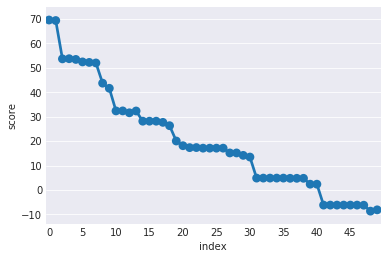

In [93]:
s = pd.concat(listofdata,axis=1)
s = s.T
s.index = s['index']

ax = sns.pointplot('index','score',data=s)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

Just from this we should be able to see that algorithm 1 is more efficient. It jumps very quickly to a low energy, but it does have it's problems (like getting stuck). Algorithm 2 on the other hand seems to just march down in energy. I wonder who would win in the long run?

If you so desire, save out the code from the notebook as a .py script and run it on your local cluster. You will have to clean things up, but the notebooks tend to crash from memory issues when you run a large number of cycles.

___

That's it!

We learned how to 

[1](#section1)- breakdown rosetta's energy for each residue 

[2](#section2)- Create a packer task and modify it to only pack residues we wanted

[3](#section3)- extract data from our rosetta run to plot energies

[4](#section4)- modify/ make decisions based on our ideas

And along the way we plotted our results!

[Click Here to goto this chapters index](#MainChapterIndex)



@author Steve J Bertolani